# Fashin MNIST classification with CNN - Tensorflow 2.1 with Keras

## Import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

TensorFlow 2.x selected.
Tensorflow version:  2.1.0


## Import dataset

In [2]:
dataset = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = dataset.load_data()
X_train, X_test = X_train / 255., X_test / 255.
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [3]:
X_train, X_test = np.expand_dims(X_train, -1), np.expand_dims(X_test, -1)
num_classes = len(set(y_train))
print('Number of classes:', num_classes)
print(X_train.shape, X_test.shape)

Number of classes: 10
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Baseline Model

In [0]:
llambda = 0.001
L2 = regularizers.l2(llambda)

In [16]:
i = Input(X_train[0].shape)
out = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(i) 
out = BatchNormalization()(out)
out = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out)
out = BatchNormalization()(out)
out = MaxPooling2D((2, 2))(out)
out = Dropout(0.4)(out) 

out = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out) 
out = BatchNormalization()(out)
out = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out) 
out = BatchNormalization()(out)
out = MaxPooling2D((2, 2))(out)
out = Dropout(0.4)(out) 

out = Flatten()(out)

out = Dense(512, activation = 'relu')(out)
out = Dropout(0.5)(out)

out = Dense(num_classes, activation = 'softmax', kernel_regularizer = L2)(out)

model = Model(i, out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0   

In [0]:
adam = Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [7]:
%%time
r = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 16s 273us/sample - loss: 0.9481 - accuracy: 0.7335 - val_loss: 0.5861 - val_accuracy: 0.8407
Epoch 2/50
60000/60000 [==============================] - 9s 155us/sample - loss: 0.6101 - accuracy: 0.8301 - val_loss: 0.4969 - val_accuracy: 0.8779
Epoch 3/50
60000/60000 [==============================] - 9s 154us/sample - loss: 0.5252 - accuracy: 0.8602 - val_loss: 0.4508 - val_accuracy: 0.8885
Epoch 4/50
60000/60000 [==============================] - 9s 155us/sample - loss: 0.4714 - accuracy: 0.8774 - val_loss: 0.4134 - val_accuracy: 0.8970
Epoch 5/50
60000/60000 [==============================] - 9s 156us/sample - loss: 0.4308 - accuracy: 0.8883 - val_loss: 0.3903 - val_accuracy: 0.9054
Epoch 6/50
60000/60000 [==============================] - 9s 158us/sample - loss: 0.4012 - accuracy: 0.8970 - val_loss: 0.3696 - val_accuracy: 0.9090
Epoch 7/50
60000/60000 [=========================

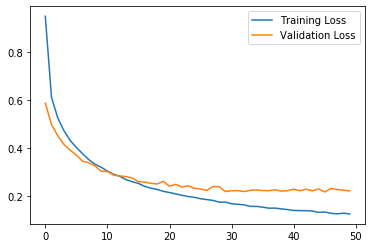

In [8]:
# 0.93337 wo dropout Conclusion: Better with dropout. Dropout rate = 0.2 - validation accuracy is 0.9401
plt.plot(r.history['loss'], label = 'Training Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()

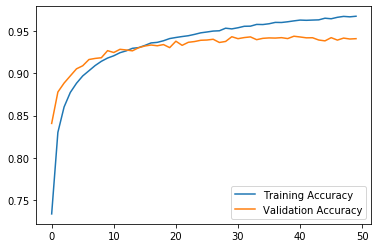

In [9]:
plt.plot(r.history['accuracy'], label = 'Training Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

## Baseline model with data augmentation

In [18]:
%%time
BATCH_SIZE = 32
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.1,
                                                                 height_shift_range = 0.1, 
                                                                 horizontal_flip = True,
                                                                 #rotation_range=90,          
                                                                 #shear_range=0.2,            
                                                                 #zoom_range=0.1,               
                                                                 #fill_mode='nearest'
                                                                 )
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.1,
                                                                 height_shift_range = 0.1,
                                                                 horizontal_flip = True,
                                                                 #rotation_range=90,          
                                                                 #shear_range=0.2,            
                                                                 #zoom_range=0.1,               
                                                                 #fill_mode='nearest'
                                                                 )
train_generator = train_data_generator.flow(X_train, y_train, BATCH_SIZE)
test_generator = test_data_generator.flow(X_test, y_test, BATCH_SIZE)
STEPS = X_train.shape[0] // BATCH_SIZE
#r = model.fit(train_generator, validation_data = (X_test, y_test), steps_per_epoch = STEPS, epochs = 100)
r = model.fit(train_generator, validation_data = test_generator, steps_per_epoch = STEPS, epochs = 100)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1875 steps, validate for 313 steps
Epoch 1/100
1875/1875 [==============================] - 21s 11ms/step - loss: 1.1794 - accuracy: 0.6491 - val_loss: 0.7535 - val_accuracy: 0.7696
Epoch 2/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.7908 - accuracy: 0.7586 - val_loss: 0.6500 - val_accuracy: 0.8087
Epoch 3/100
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6902 - accuracy: 0.7944 - val_loss: 0.5896 - val_accuracy: 0.8332
Epoch 4/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.6174 - accuracy: 0.8193 - val_loss: 0.5551 - val_accuracy: 0.8478
Epoch 5/100
1875/1875 [==============================] - 20s 11ms/step - loss: 0.5711 - accuracy: 0.8346 - val_loss: 0.5055 - val_accuracy: 0.8590
Epoch 6/100
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5343 - accuracy: 0.8457 - val_loss: 0.4598 - val_accuracy: 0.8698
Epoch 7/100
1875/1875 [

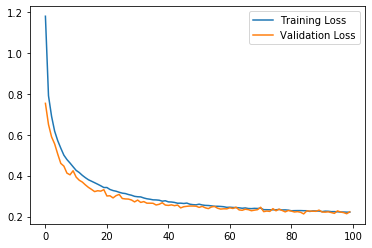

In [19]:
# Validation accuracy is 0.942 without dropout Conclusion: Here the dropout doesn't make significant difference. Val acc: 0.9417
plt.plot(r.history['loss'], label = 'Training Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()

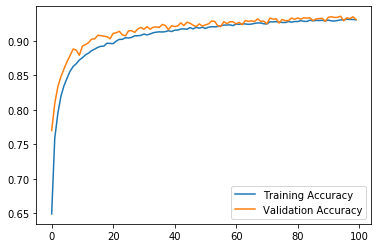

In [20]:
plt.plot(r.history['accuracy'], label = 'Training Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

## Model with 3 convolutional blocks

In [0]:
llambda = 0.01
L2 = regularizers.l2(llambda)

In [41]:
i = Input(X_train[0].shape)
out = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(i)
out = BatchNormalization()(out)
out = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out)
out = BatchNormalization()(out)
out = MaxPooling2D((2, 2))(out)
out = Dropout(0.2)(out) 

out = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out) 
out = BatchNormalization()(out)
out = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out) 
out = BatchNormalization()(out)
out = MaxPooling2D((2, 2))(out)
out = Dropout(0.4)(out) 

out = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out)
out = BatchNormalization()(out)
out = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = L2)(out)
out = BatchNormalization()(out)
out = MaxPooling2D((2, 2))(out)
out = Dropout(0.5)(out)

out = Flatten()(out)
out = Dropout(0.5)(out)

#out = Dense(1024, activation = 'relu', kernel_regularizer = L2)(out)
#out = Dropout(0.5)(out)

out = Dense(512, activation = 'relu', kernel_regularizer = L2)(out)
out = Dropout(0.5)(out)

out = Dense(num_classes, activation = 'softmax', kernel_regularizer = L2)(out)

model = Model(i, out)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 32)        0   

In [0]:
adam = Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [33]:
%%time
r = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 208us/sample - loss: 11.3929 - accuracy: 0.5539 - val_loss: 8.8054 - val_accuracy: 0.7617
Epoch 2/50
60000/60000 [==============================] - 11s 190us/sample - loss: 7.2384 - accuracy: 0.7326 - val_loss: 5.4611 - val_accuracy: 0.8080
Epoch 3/50
60000/60000 [==============================] - 11s 187us/sample - loss: 4.2142 - accuracy: 0.7968 - val_loss: 3.0150 - val_accuracy: 0.8399
Epoch 4/50
60000/60000 [==============================] - 11s 188us/sample - loss: 2.3257 - accuracy: 0.8420 - val_loss: 1.6892 - val_accuracy: 0.8777
Epoch 5/50
60000/60000 [==============================] - 11s 185us/sample - loss: 1.3778 - accuracy: 0.8680 - val_loss: 1.0681 - val_accuracy: 0.8897
Epoch 6/50
60000/60000 [==============================] - 11s 189us/sample - loss: 0.9469 - accuracy: 0.8832 - val_loss: 0.7908 - val_accuracy: 0.8983
Epoch 7/50
60000/60000 [===================

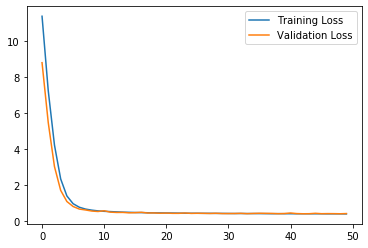

In [34]:
plt.plot(r.history['loss'], label = 'Training Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()

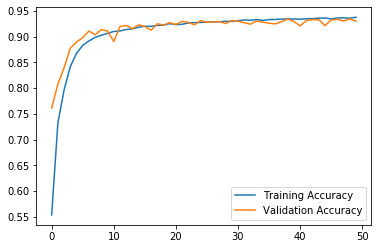

In [35]:
plt.plot(r.history['accuracy'], label = 'Training Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

In [43]:
%%time
BATCH_SIZE = 32
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.1,
                                                                 height_shift_range = 0.1,
                                                                 horizontal_flip = True,
                                                                 #rotation_range=90,          
                                                                 #shear_range=0.2,            
                                                                 #zoom_range=0.1,               
                                                                 #fill_mode='nearest'
                                                                 )
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.1,
                                                                 height_shift_range = 0.1,
                                                                 horizontal_flip = True,
                                                                 #rotation_range=90,          
                                                                 #shear_range=0.2,            
                                                                 #zoom_range=0.1,               
                                                                 #fill_mode='nearest'
                                                                 )
train_generator = train_data_generator.flow(X_train, y_train, BATCH_SIZE)
test_generator = test_data_generator.flow(X_test, y_test, BATCH_SIZE)
STEPS = X_train.shape[0] // BATCH_SIZE
#r = model.fit(train_generator, validation_data = (X_test, y_test), steps_per_epoch = STEPS, epochs = 100)
r = model.fit(train_generator, validation_data = test_generator, steps_per_epoch = STEPS, epochs = 250)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1875 steps, validate for 313 steps
Epoch 1/250
1875/1875 [==============================] - 22s 12ms/step - loss: 11.8212 - accuracy: 0.4506 - val_loss: 9.1093 - val_accuracy: 0.6984
Epoch 2/250
1875/1875 [==============================] - 21s 11ms/step - loss: 7.6472 - accuracy: 0.6628 - val_loss: 5.8764 - val_accuracy: 0.7493
Epoch 3/250
1875/1875 [==============================] - 21s 11ms/step - loss: 4.6500 - accuracy: 0.7387 - val_loss: 3.4340 - val_accuracy: 0.7721
Epoch 4/250
1875/1875 [==============================] - 21s 11ms/step - loss: 2.6639 - accuracy: 0.7850 - val_loss: 1.9487 - val_accuracy: 0.8222
Epoch 5/250
1875/1875 [==============================] - 21s 11ms/step - loss: 1.6138 - accuracy: 0.8148 - val_loss: 1.2505 - val_accuracy: 0.8471
Epoch 6/250
1875/1875 [==============================] - 21s 11ms/step - loss: 1.1228 - accuracy: 0.8391 - val_loss: 0.9369 - val_accuracy: 0.8614
Epoch 7/250
1875/1875 

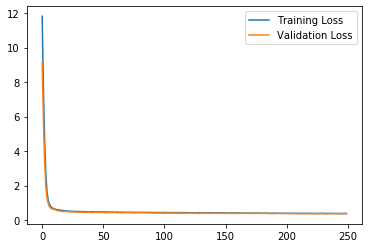

In [44]:
plt.plot(r.history['loss'], label = 'Training Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()

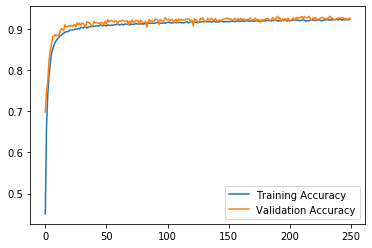

In [45]:
plt.plot(r.history['accuracy'], label = 'Training Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()